# Slicing script for images
This script can import any of the 4 image sources. The geochemical data is brought in by the auxillary script, db_import_sp and the coordinates are converted between GPS, UTM and pixel locations. The script plots a red square centered on the coordinate and slices out an image of n x n pixels. Each square is assigned its sample ID and is saved as such as a .png file. The files are split between 5 categories of nickel content in PPM. They are further more split into training and validation folders.

In [5]:
"""

Created on Tue Aug 28 14:09:11 2018

@author: kongstad
Script for loading up images, reading the geographic coordinates and 
preperation for image slicing.
"""

# official
import os
import pandas as pd
import numpy as np
import rasterio
import rasterio.features
import rasterio.warp
from matplotlib import pyplot,patches 
from rasterio.plot import show
from collections import defaultdict
import operator
import split_folders

# Import auxillary script
import db_import_sp

# Handling project directory file name.
project_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

### Reads the image in. In this case the S2 L2A image

In [6]:
#%% Read image into Rasterio

# This is the structural geology map
dataset = rasterio.open(project_dir + '/data/satellite_data/S2/merged/L2A_merged/TCI.tif')

img=dataset.read()

### Defines path to geochemical dataset and passes it to auxillary script.

In [7]:
#%% Path to database and loading it into the measurement class.
measurements = db_import_sp.measurement(project_dir + '/data/21st_files/datasheet/cleaned/21N-R-Multi-AqR_watclr.xlsx')
measurements.loadFile()
 

### Reads the size of the input image. When using single band Sentinel-2 images, the images often vary in size. This is later used to tell the script to only accept datapoints within the region of the satellite image.

In [8]:
#%% Read file size to automatically change it for the patch part
# This is used for S-2 single bands that vary in resolution size.
imgdimx = img.shape[1]
imgdimy = img.shape[2]

### The columns of interest in the database are made easier to access as they can be called by the element name rather than column 26, 28 and so on. Also imports the conversion done in the auxillary script.

In [9]:
#%% Imports the relevant ID's from db_import
measurements.coord_LatLon = measurements.extractData('Coordinates')
measurements.id = measurements.extractData('Sample_ID')
measurements.type = measurements.extractData('Type')
measurements.ni = measurements.extractData('Ni')
measurements.cu = measurements.extractData('Cu')
measurements.cr = measurements.extractData('Cr')
measurements.ba = measurements.extractData('Ba')
measurements.sr = measurements.extractData('Sr')

# Imports the conversion between Pixels <--> UTM <--> LatLon
measurements.LatLong2UTM()
measurements.UTM2Pixel(dataset.transform)

Extracted Column: 3
Extracted Column: 2
Extracted Column: 1
Extracted Column: 26
Extracted Column: 16
Extracted Column: 15
Extracted Column: 9
Extracted Column: 32


### Displays the imported satellite image and defines the size of the patches to be sliced.

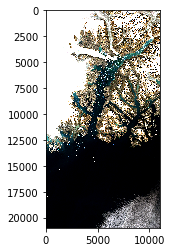

In [10]:
#%% Show the loaded Rasterio image and define patch size of bounding boxes
fig=show(img)

patch_size = 64


### Filtering that avoids duplicates and filters off samples that have identical coordinates in such that the maximum nickel value is kept for a location.

In [12]:
#%% Find the ID's with exact same coordinates to avoid replicating the same patch
seen = set()
measurements.coord_Pixel_dedup = []
measurements.id_dedup = []


def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)

filtered_duplicates = []
for dup in sorted(list_duplicates(measurements.coord_Pixel)):
    idx = dup[1]
    dup_ni = [measurements.ni[i] for i in idx]
    #print(dup_ni)
    index, value = max(enumerate(dup_ni), key=operator.itemgetter(1))
    #print(idx)
    idx.pop(index)
    #print(idx)
    filtered_duplicates.append(idx)
    
filtered_duplicates = [item for sublist in filtered_duplicates for item in sublist]
filtered_duplicates.sort()

#print(filtered_duplicates)

for index in sorted(filtered_duplicates, reverse=True):
    #print(index)
    del measurements.coord_Pixel[index]
    del measurements.id[index]
 
    
measurements.coord_Pixel_dedup = measurements.coord_Pixel
measurements.id_dedup = measurements.id

#print(len(measurements.coord_Pixel_dedup))

### Loads in a seperate txt file with the samples that have no nickel values to filter them out. This section generates the red bounding boxes that slices out 64x64 images and stores them in 5 seperate folders as .png files with their sample id as their name.
This part of the jupyter file is not executed as it prints an empty line for every sample being saved. The output is 5 folders representing the 5 nickel categories, each with 2 subfolders of training and validation data. At the end, the previously shown satellite map is loaded with all red patches and their sample ID annoation shown.

In [ ]:
#%% Drawing bounding boxes with their center on each coordinate
        
# Since some data is located in the water, this acts as a manuel filter, in
# where every ID sample that is unwanted, is entered into the text file, thus being removed.
        
k=0
flip = 0
with open(project_dir + '/data/21st_files/datasheet/no_ni_values.txt') as text_file:
    no_ni_values = [x.rstrip() for x in text_file]

idx = 0
for idx,m in enumerate(measurements.coord_Pixel_dedup): 
    # This is a filter to only accept inliers. Samples that arent within the image
    if m[0] <= 10960 and m[0] >=0 and m[1] <= 21920 and m[1] >=0: 
        x1=m[0]-patch_size/2
        x2=m[0]+patch_size/2
        y1=m[1]-patch_size/2
        y2=m[1]+patch_size/2

        # Part for cutting out image patches
        img_patch1 = img[0,int(y1):int(y2),int(x1):int(x2)]
        img_patch2 = img[1,int(y1):int(y2),int(x1):int(x2)]
        img_patch3 = img[2,int(y1):int(y2),int(x1):int(x2)]
        
        # Stacks the 3 bands in correct order
        img_patch = np.dstack([img_patch1,img_patch2,img_patch3])
        
        # If the ID is located in the water sample, it is removed
        if str(measurements.id_dedup[idx]) in set(no_ni_values):            
            print('NaN Nickel samples removed! ' + str(measurements.id_dedup[idx]))
            
        else:
            # Create rectangle for plot        
            patch = patches.Rectangle((x1,y1),patch_size,patch_size,fill=False,color='r',)
            
            # Uncomment this bit for annotation for trouble shooting.
            # Flipping is added as some of the annotation got layered ontop of each other.
            if flip==1:
                annotation_pos = (x1,y1)
                flip=0
            else:
                annotation_pos = (x1,y2)
                flip=1
            # Annotates the rectangles  
            pyplot.annotate(s='Sample ID: '+ str(measurements.id_dedup[idx]), xy=annotation_pos, color="white")
            
            
            # Add patch to figure
            fig.add_patch(patch)

          
            # Saves figures based on their nickel content
            if measurements.id[idx]:
                if measurements.ni[idx] <26:
                    pyplot.imsave(project_dir + '/data/extracted_patches/S2/visible_spec/64px/1/' + str(measurements.id[idx]) + '.png' ,img_patch, format='png')                  
                    
                if measurements.ni[idx] > 25 and measurements.ni[idx] < 101:
                    pyplot.imsave(project_dir + '/data/extracted_patches/S2/visible_spec/64px/2/' + str(measurements.id[idx]) + '.png' ,img_patch, format='png')        
                
                if measurements.ni[idx] > 100 and measurements.ni[idx]  < 251:
                    pyplot.imsave(project_dir + '/data/extracted_patches/S2/visible_spec/64px/3/' + str(measurements.id[idx]) + '.png' ,img_patch, format='png')           
                
                if measurements.ni[idx] > 250 and measurements.ni[idx]  < 800:
                    pyplot.imsave(project_dir + '/data/extracted_patches/S2/visible_spec/64px/4/' + str(measurements.id[idx]) + '.png' ,img_patch, format='png')            
                
                if measurements.ni[idx] > 800:
                    pyplot.imsave(project_dir + '/data/extracted_patches/S2/visible_spec/64px/5/' + str(measurements.id[idx]) + '.png' ,img_patch, format='png')
           
            
# Splits the images into 70 % training data and 30% validation data
split_folders.ratio(project_dir + '/data/extracted_patches/S2/visible_spec/64px/',
                    output=project_dir + '/data/extracted_patches/S2/visible_spec/64px_mysplit/', 
                    seed=1337, ratio=(.7, .3)) 

            
pyplot.show()